AI-Powered Food Classification and Calorie Estimation Using the Food-101 Dataset  
Abdallah Waked  
INFO-6147 Deep Learning with PyTorch  
Dr. Mohammed Yousefhussien  
Apr 12, 2025  


In [ ]:
import os
import json
import copy

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from torch.utils.data import random_split

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader


Create a data folder to save the Food-101 dataset locally.

In [18]:
dataset_path = './data'
os.makedirs(dataset_path, exist_ok=True)

The code downloads the Food-101 dataset, applies image transformations, splits it into training, validation, and test sets, and prepares DataLoaders for training.

In [19]:
def get_dataloaders(batch_size=32):
    transform_train = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    transform_test = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    dataset_path = './data'
    full_train_dataset = datasets.Food101(root=dataset_path, split='train', transform=transform_train, download=True)
    test_dataset = datasets.Food101(root=dataset_path, split='test', transform=transform_test, download=True)

    train_size = int(0.85 * len(full_train_dataset))
    val_size = len(full_train_dataset) - train_size
    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

    classes = full_train_dataset.classes
    return train_loader, val_loader, test_loader, classes

train_loader, val_loader, test_loader, classes = get_dataloaders(batch_size=32)
print(f"Data ready. Classes: {len(classes)}")

Data ready. Classes: 101


This function builds a ResNet-18 model for Food-101. If pretrained=True, it uses pre-trained weights. If freeze_layers=True, it freezes most layers except the last block (layer4) and the final fully connected layer (fc) for fine-tuning. Finally, it adjusts the output layer to match the number of classes.

In [20]:
def build_model(num_classes=101, pretrained=True, freeze_layers=False):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)

    if pretrained and freeze_layers:
        for param in model.parameters():
            param.requires_grad = False
        for name, param in model.named_parameters():
            if 'layer4' in name or 'fc' in name:
                param.requires_grad = True
    else:
        for param in model.parameters():
            param.requires_grad = True

    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


Train, validate, save progress, resume if interrupted, and store the best model and training history.

In [ ]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=15, experiment_name='baseline', hyperparameters=None):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Directories
    model_dir = f"./models/{experiment_name}"
    eval_dir = f"./evaluation/{experiment_name}"
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(eval_dir, exist_ok=True)

    # === Load history data (safe) ===
    history_file = os.path.join(eval_dir, 'training_history.json')
    history_data = {}
    history = []

    if os.path.exists(history_file):
        with open(history_file, 'r') as f:
            history_data = json.load(f)
            history = history_data.get('history', [])
            print(f"Resuming history, found {len(history)} previous epochs")

    # === Load previous best model if exists ===
    best_model_path = os.path.join(model_dir, 'food101_checkpoint_best.pth')
    if os.path.exists(best_model_path):
        print(f"Loading previous best model: {best_model_path}")
        best_model_wts = torch.load(best_model_path, map_location=device)
        model.load_state_dict(best_model_wts)

        if history:
            best_acc = max(h['val_acc'] for h in history)
            print(f"Previous best accuracy: {best_acc:.2f}%")

    # === Determine start epoch ===
    start_epoch = history[-1]['epoch'] + 1 if history else 1

    # === Training loop ===
    for epoch in range(start_epoch, start_epoch + num_epochs):
        print(f"\nEpoch {epoch}/{start_epoch + num_epochs - 1}")
        print("-" * 20)

        # ==== Training ====
        model.train()
        train_loss, train_correct, total_train = 0.0, 0, 0
        for images, labels in tqdm(train_loader, desc="Training", leave=False):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_epoch_loss = train_loss / total_train
        train_epoch_acc = train_correct / total_train * 100

        # ==== Validation ====
        model.eval()
        val_loss, val_correct, total_val = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation", leave=False):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * labels.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_epoch_loss = val_loss / total_val
        val_epoch_acc = val_correct / total_val * 100

        print(f"Train Loss: {train_epoch_loss:.4f} Acc: {train_epoch_acc:.2f}%")
        print(f"Val   Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.2f}%")

        # ===Check for best model ===
        if val_epoch_acc > best_acc:
            best_acc = val_epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, best_model_path)
            print(f"Saved new best model with acc: {best_acc:.2f}%")

        # === Append history safely ===
        history.append({
            'epoch': epoch,
            'train_loss': train_epoch_loss,
            'train_acc': train_epoch_acc,
            'val_loss': val_epoch_loss,
            'val_acc': val_epoch_acc
        })

        # ==== Update history_data with latest hyperparameters and history
        history_data = {
            "hyperparameters": hyperparameters,
            "history": history
        }

        with open(history_file, 'w') as f:
            json.dump(history_data, f, indent=4)

    print(f"\nTraining complete! Best Val Acc: {best_acc:.2f}%")

    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), os.path.join(model_dir, 'food101_checkpoint_final.pth'))

    return model, history

This function loads a saved model, evaluates it on test data, and returns accuracy and predictions

In [ ]:
def evaluate_model_from_path(model_path, dataloader, device, num_classes, build_model_func):
    model = build_model_func(num_classes=num_classes)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)

    model.to(device)
    model.eval()

    correct, total = 0, 0
    all_labels, all_preds = [], []

    from tqdm import tqdm
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Testing", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = correct / total * 100
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy, all_labels, all_preds


These functions visualize model performance: one shows training progress, and the other shows classification errors.

In [8]:
def plot_training_history(history):
    epochs = [h['epoch'] for h in history]
    train_acc = [h['train_acc'] for h in history]
    val_acc = [h['val_acc'] for h in history]
    train_loss = [h['train_loss'] for h in history]
    val_loss = [h['val_loss'] for h in history]

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Train Acc')
    plt.plot(epochs, val_acc, label='Val Acc')
    plt.legend()
    plt.title('Accuracy')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.legend()
    plt.title('Loss')
    plt.grid()

    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameter grid
param_grid = [
    {"lr": 0.001, "batch_size": 16, "freeze_layers": True},
    {"lr": 0.0003, "batch_size": 8, "freeze_layers": True},
]

# Experiment modes
experiment_modes = ['baseline','pretrained_freeze', 'pretrained_unfreeze'] 


for params in param_grid:
    for experiment in experiment_modes:
        print(f"\nStarting Experiment: {experiment} | Params: {params}")

        # Dynamic parameters
        lr = params['lr']
        batch_size = params['batch_size']
        freeze = params['freeze_layers']
        pretrained = experiment != 'baseline'

        # Update loaders dynamically
        train_loader, val_loader, test_loader, classes = get_dataloaders(batch_size=batch_size)

        # Build model
        model = build_model(num_classes=len(classes), pretrained=pretrained, freeze_layers=freeze).to(device)

        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        # Optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Dynamic experiment name
        experiment_name = f"{experiment}_lr{lr}_bs{batch_size}_freeze{freeze}"

        # Train
        model, history = train_and_validate(
            model, train_loader, val_loader,
            criterion, optimizer, device,
            num_epochs=10,  
            experiment_name=experiment_name,
            hyperparameters=params  
        )

print("\nAll experiments completed!")


Manually select the model path, run the evaluation, and the script will save accuracy, classification report, and confusion matrix as JSON for later use in the web app.

In [ ]:
import json
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Evaluate model
test_acc, all_labels, all_preds = evaluate_model_from_path(
    model_path="food101_checkpoint_best.pth",
    dataloader=test_loader,
    device=device,
    num_classes=len(classes),
    build_model_func=build_model
)

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=classes, output_dict=True)

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Print for checking
print(json.dumps(report, indent=4))
print("Confusion Matrix:")
print(cm)

# Save results to JSON
result = {
    "test_accuracy": test_acc,
    "classification_report": report,
    "confusion_matrix": cm.tolist(), 
    "classes": classes 
}

with open("./evaluation/model_evaluation_results.json", "w") as f:
    json.dump(result, f, indent=4)

print("Results saved to ./evaluation/model_evaluation_results.json")


C:\Users\abd_w\AppData\Local\Temp\ipykernel_19588\3133977915.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


Test Accuracy: 45.92%
                         precision    recall  f1-score   support

              apple_pie       0.34      0.07      0.11       250
         baby_back_ribs       0.46      0.49      0.48       250
                baklava       0.38      0.53      0.44       250
         beef_carpaccio       0.67      0.54      0.60       250
           beef_tartare       0.80      0.25      0.38       250
             beet_salad       0.50      0.28      0.36       250
               beignets       0.67      0.62      0.65       250
               bibimbap       0.63      0.76      0.69       250
          bread_pudding       0.31      0.23      0.26       250
      breakfast_burrito       0.30      0.10      0.15       250
             bruschetta       0.34      0.32      0.33       250
           caesar_salad       0.36      0.78      0.50       250
                cannoli       0.51      0.28      0.37       250
          caprese_salad       0.31      0.51      0.38       250
  

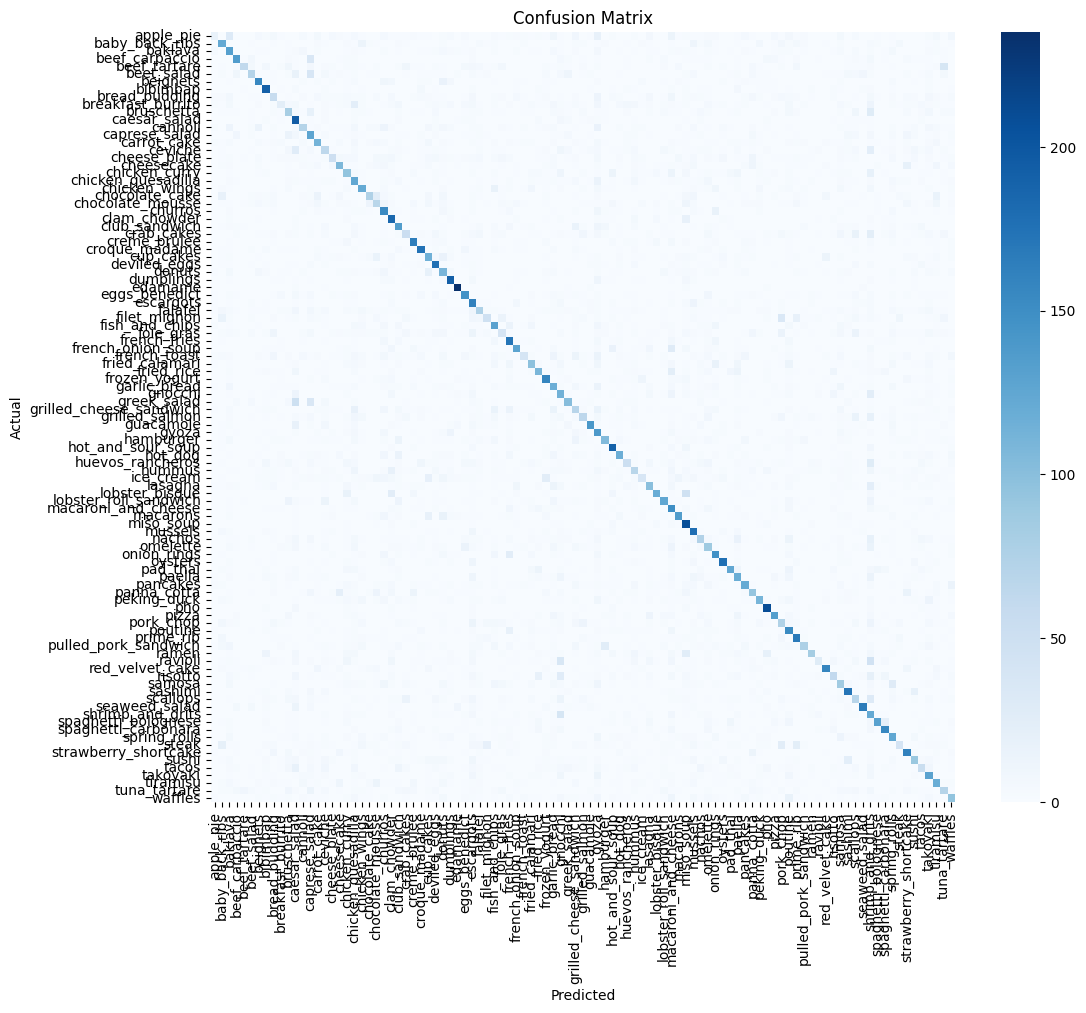

In [13]:
test_acc, all_labels, all_preds = evaluate_model_from_path(
    model_path="food101_checkpoint_best.pth",
    dataloader=test_loader,
    device=device,
    num_classes=len(classes),
    build_model_func=build_model
)


from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=classes))

plot_confusion_matrix(all_labels, all_preds, classes)


C:\Users\abd_w\AppData\Local\Temp\ipykernel_21284\1270799485.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Test Accuracy: 47.97%
                         precision    recall  f1-score   support

              apple_pie       0.50      0.11      0.18       250
         baby_back_ribs       0.42      0.53      0.47       250
                baklava       0.58      0.53      0.55       250
         beef_carpaccio       0.63      0.50      0.56       250
           beef_tartare       0.27      0.50      0.35       250
             beet_salad       0.27      0.49      0.35       250
               beignets       0.78      0.68      0.72       250
               bibimbap       0.50      0.81      0.62       250
          bread_pudding       0.41      0.12      0.19       250
      breakfast_burrito       0.53      0.14      0.22       250
             bruschetta       0.26      0.36      0.30       250
           caesar_salad       0.62      0.39      0.48       250
                cannoli       0.75      0.35      0.48       250
          caprese_salad       0.37      0.56      0.45       250
  

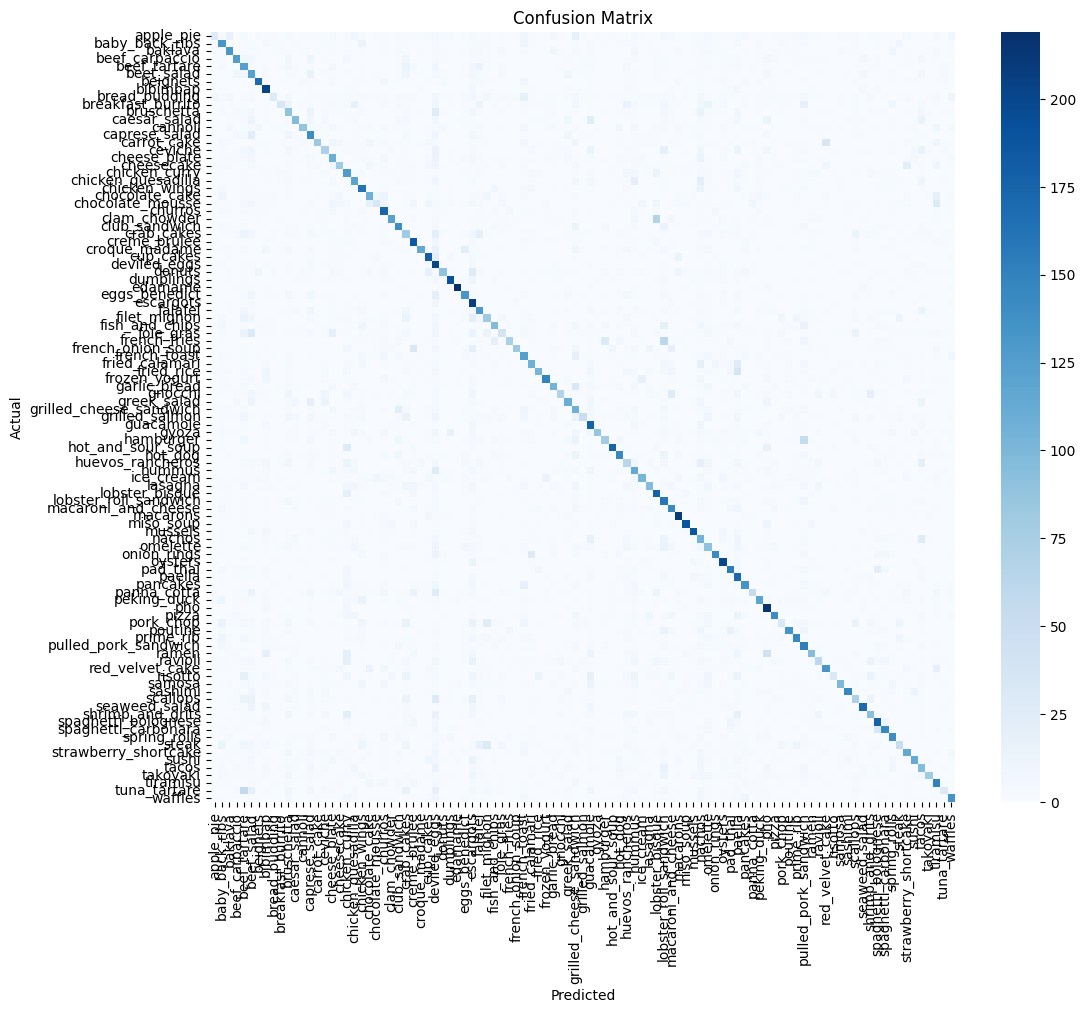

In [23]:
test_acc, all_labels, all_preds = evaluate_model_from_path(
    model_path="food101_checkpoint_best.pth",
    dataloader=test_loader,
    device=device,
    num_classes=len(classes),
    build_model_func=build_model
)


from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=classes))

plot_confusion_matrix(all_labels, all_preds, classes)


C:\Users\abd_w\AppData\Local\Temp\ipykernel_21284\1270799485.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Test Accuracy: 34.58%
                         precision    recall  f1-score   support

              apple_pie       0.39      0.07      0.12       250
         baby_back_ribs       0.26      0.34      0.30       250
                baklava       0.44      0.43      0.43       250
         beef_carpaccio       0.31      0.58      0.41       250
           beef_tartare       0.27      0.26      0.26       250
             beet_salad       0.29      0.30      0.30       250
               beignets       0.77      0.45      0.57       250
               bibimbap       0.23      0.74      0.35       250
          bread_pudding       0.41      0.04      0.08       250
      breakfast_burrito       0.14      0.08      0.10       250
             bruschetta       0.19      0.26      0.22       250
           caesar_salad       0.29      0.49      0.36       250
                cannoli       0.45      0.30      0.36       250
          caprese_salad       0.32      0.29      0.30       250
  

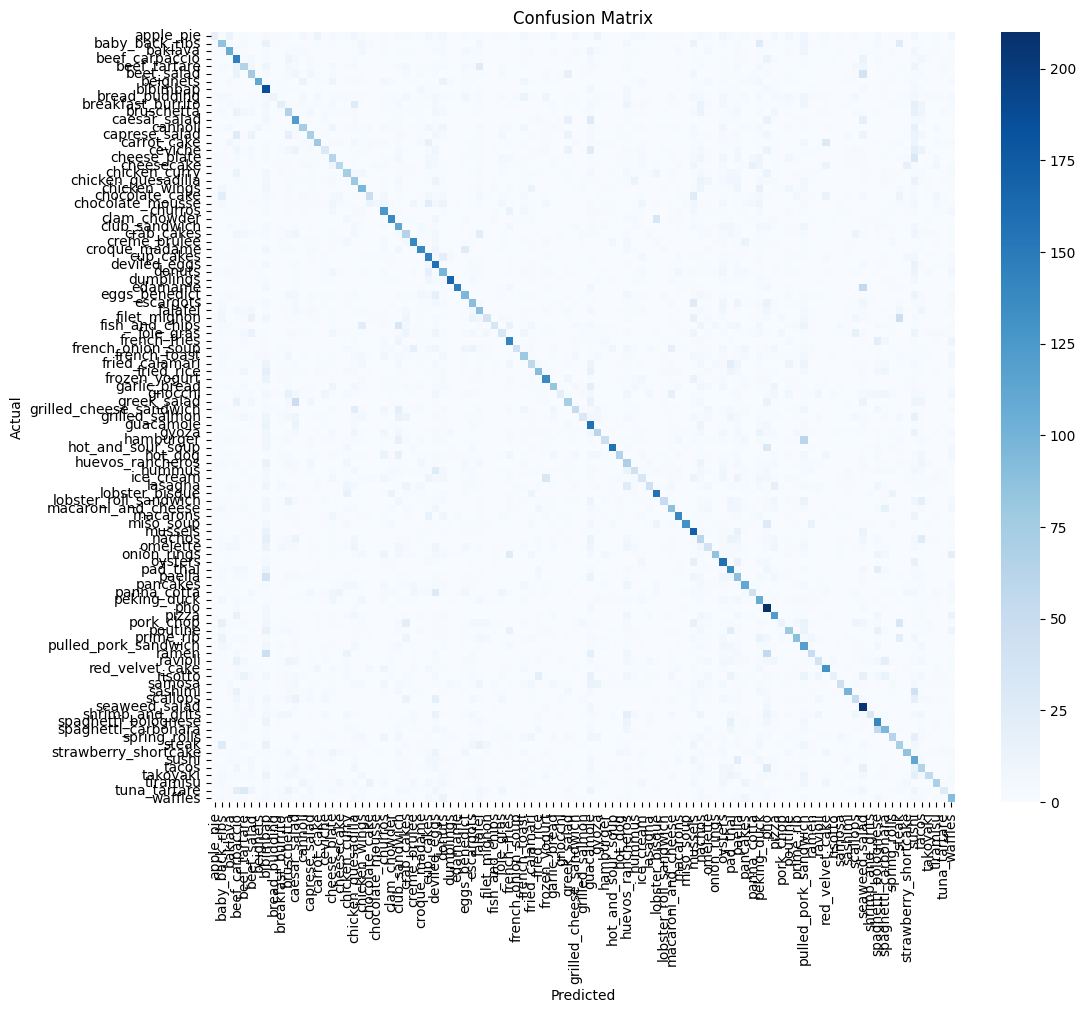

In [25]:
test_acc, all_labels, all_preds = evaluate_model_from_path(
    model_path="food101_checkpoint_best2.pth",
    dataloader=test_loader,
    device=device,
    num_classes=len(classes),
    build_model_func=build_model
)


from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=classes))

plot_confusion_matrix(all_labels, all_preds, classes)


C:\Users\abd_w\AppData\Local\Temp\ipykernel_21284\3133977915.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


Test Accuracy: 42.57%
                         precision    recall  f1-score   support

              apple_pie       0.32      0.03      0.05       250
         baby_back_ribs       0.61      0.29      0.39       250
                baklava       0.32      0.54      0.40       250
         beef_carpaccio       0.82      0.34      0.48       250
           beef_tartare       0.43      0.24      0.31       250
             beet_salad       0.42      0.26      0.33       250
               beignets       0.61      0.71      0.65       250
               bibimbap       0.72      0.63      0.67       250
          bread_pudding       0.30      0.15      0.20       250
      breakfast_burrito       0.23      0.03      0.05       250
             bruschetta       0.63      0.12      0.20       250
           caesar_salad       0.29      0.66      0.40       250
                cannoli       0.36      0.51      0.42       250
          caprese_salad       0.47      0.22      0.30       250
  

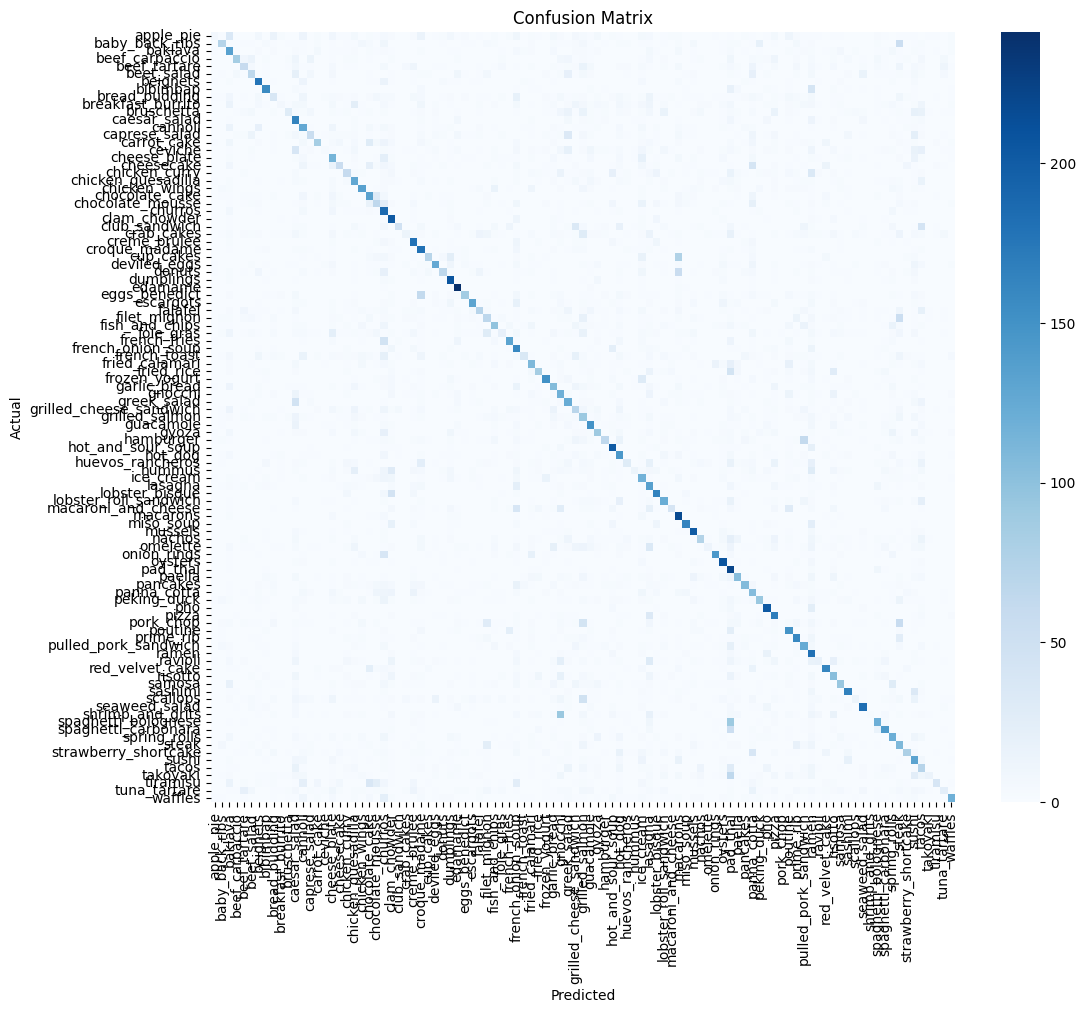

In [ ]:
test_acc, all_labels, all_preds = evaluate_model_from_path(
    model_path="food101_checkpoint_best3.pth",
    dataloader=test_loader,
    device=device,
    num_classes=len(classes),
    build_model_func=build_model
)


from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=classes))

plot_confusion_matrix(all_labels, all_preds, classes)


C:\Users\abd_w\AppData\Local\Temp\ipykernel_21284\3133977915.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


Test Accuracy: 45.92%
                         precision    recall  f1-score   support

              apple_pie       0.34      0.07      0.11       250
         baby_back_ribs       0.46      0.49      0.48       250
                baklava       0.38      0.53      0.44       250
         beef_carpaccio       0.67      0.54      0.60       250
           beef_tartare       0.80      0.25      0.38       250
             beet_salad       0.50      0.28      0.36       250
               beignets       0.67      0.62      0.65       250
               bibimbap       0.63      0.76      0.69       250
          bread_pudding       0.31      0.23      0.26       250
      breakfast_burrito       0.30      0.10      0.15       250
             bruschetta       0.34      0.32      0.33       250
           caesar_salad       0.36      0.78      0.50       250
                cannoli       0.51      0.28      0.37       250
          caprese_salad       0.31      0.51      0.38       250
  

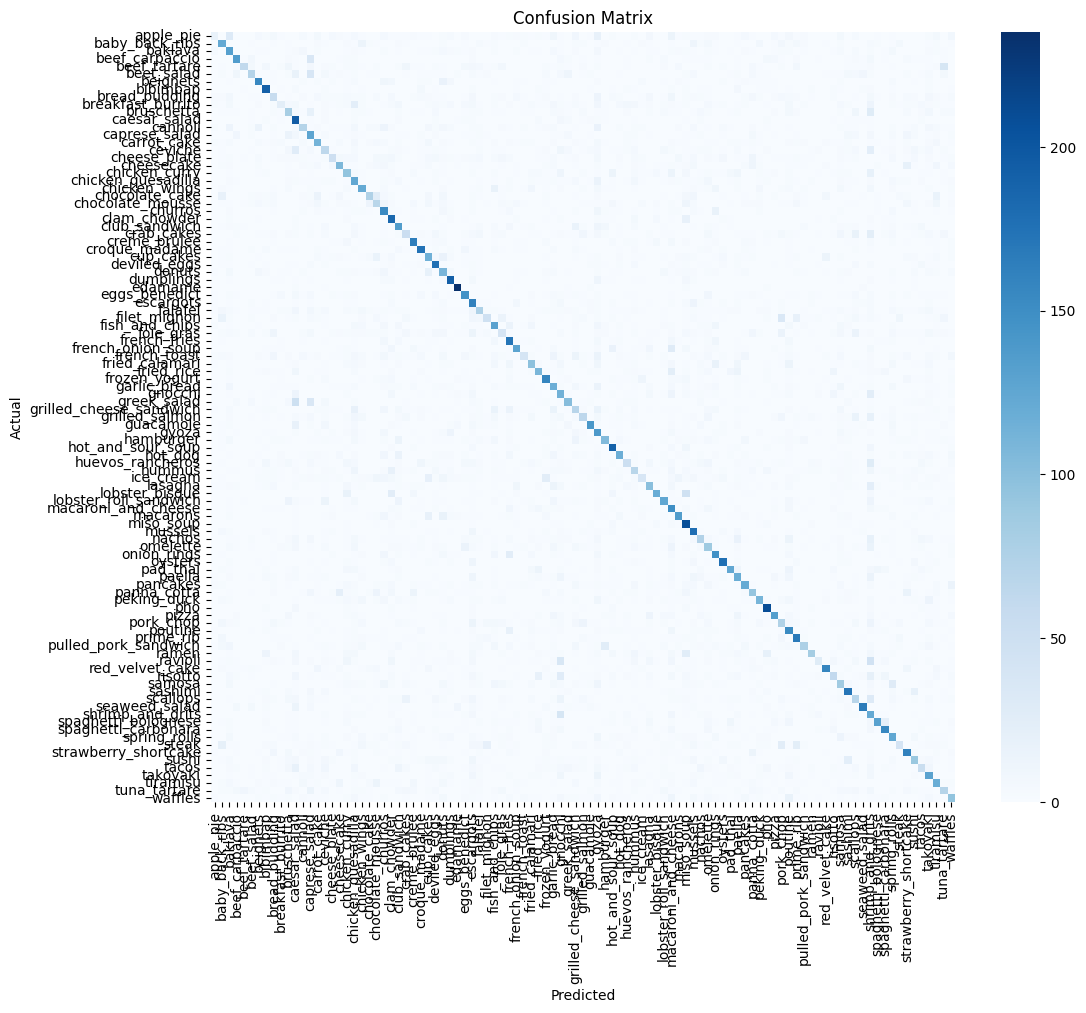

In [ ]:
test_acc, all_labels, all_preds = evaluate_model_from_path(
    model_path="food101_checkpoint_best.pth",
    dataloader=test_loader,
    device=device,
    num_classes=len(classes),
    build_model_func=build_model
)


from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=classes))

plot_confusion_matrix(all_labels, all_preds, classes)


In [10]:
import torch
from utils.model_utils import build_model
from utils.data_loader import test_loader, classes
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import json
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def evaluate_model_from_path(model_path, dataloader, device, num_classes, build_model_func):
    model = build_model_func(num_classes=num_classes)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)

    model.to(device)
    model.eval()

    correct, total = 0, 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = correct / total * 100
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=classes, output_dict=True)

    return accuracy, report, cm

def save_evaluation_results(accuracy, report, cm, output_path):
    results = {
        "accuracy": accuracy,
        "classification_report": report,
        "confusion_matrix": cm.tolist(),
        "classes": classes  # Save classes as well for loading later
    }

    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    with open(output_path, 'w') as f:
        json.dump(results, f, indent=4)

    print(f"✅ Evaluation results saved to: {output_path}")

def plot_confusion_matrix(cm, class_names):
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_path = "./models/baseline_lr0.001_bs8_freezeTrue/food101_checkpoint_best.pth"

print("🚀 Starting evaluation...")
accuracy, report, cm = evaluate_model_from_path(
        model_path=model_path,
        dataloader=test_loader,
        device=device,
        num_classes=len(classes),
        build_model_func=build_model
)

print(f"✅ Test Accuracy: {accuracy:.2f}%")
print("\n📊 Classification Report:")
print(json.dumps(report, indent=4))  # Pretty print

print("\n🧩 Confusion Matrix:")
print(cm)

    # Optional: visualize
plot_confusion_matrix(cm, class_names=classes)

    # Save to JSON
save_evaluation_results(
        accuracy=accuracy,
        report=report,
        cm=cm,
        output_path="./evaluation_results/evaluation.json"
    )


ModuleNotFoundError: No module named 'utils'